# Nutritional Inequality and Food Prices  

## Introduction  

Nutritional inequality refers to disparities in diet quality and access to healthy food across different socioeconomic groups. Rising food prices, food deserts, and lack of nutrition education contribute to this issue, affecting millions of Americans. As of 2025, **around 40 million Americans** experience food insecurity, with many turning to cheaper, less nutritious options due to affordability and accessibility challenges.  

In this project, we explore **how food prices impact dietary choices and accessibility across different regions and income levels**. Our research focuses on:  

- **Comparing** the cost of nutrient-dense foods (fruits, vegetables) versus processed foods  
- **Analyzing** geographical disparities in food availability (food deserts)  
- **Investigating** the role of socioeconomic factors in nutritional choices 

To address these questions, we leverage publicly available datasets from **USDA, BLS, FAO, and Kaggle**, integrating statistical analysis and visualization techniques. Our goal is to uncover meaningful insights into the systemic causes of nutritional inequality and potential policy interventions.  

---  
### Notebook Workflow  
🔹 **Data Wrangling:** Cleaning and preprocessing datasets  
🔹 **Combining Data:** Merging multiple sources for comprehensive analysis  
🔹 **Statistical Analysis:** Identifying correlations between food prices, income, and access  
🔹 **Visualization:** Presenting trends and disparities through charts and maps  

This notebook serves as a prototype for our analysis, demonstrating key data transformations, exploratory statistics, and preliminary findings. 🚀  

In [82]:
# Load in packages

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
# others

In [55]:
# Load in datasets
folder_path = 'project data/'

historical_changes_consumer_price = pd.read_csv(folder_path + '(historical) changes_consumer_price.csv')
historical_producer_price_changes = pd.read_csv(folder_path + '(historical) producer_price_changes.csv')
consumer_price = pd.read_csv(folder_path + 'changes_consumer_price_indices.csv')
producer_price = pd.read_csv(folder_path + 'changes_producer_price.csv')
state_and_county = pd.read_csv(folder_path + 'StateAndCountyData.csv')
variable_list = pd.read_csv(folder_path + 'VariableList.csv')

## Data Wrangling 

### For CPI + PPI 

In [56]:
historical_producer_price_changes.head()

,Producer Price Index item,Year,Percent change
0,Unprocessed foodstuffs and feedstuffs,1974,5.2
1,Unprocessed foodstuffs and feedstuffs,1975,1.3
2,Unprocessed foodstuffs and feedstuffs,1976,-0.8
3,Unprocessed foodstuffs and feedstuffs,1977,0.9
4,Unprocessed foodstuffs and feedstuffs,1978,12.6


In [57]:
## Showing data
historical_changes_consumer_price.head()

,Consumer Price Index item,Year,Percent change
0,All food,1974,14.3
1,All food,1975,8.5
2,All food,1976,3.0
3,All food,1977,6.3
4,All food,1978,9.9


In [72]:
# cleaning historical producer price changes + consumer price 

historical_producer_price_changes['Year'] = pd.to_numeric(historical_producer_price_changes['Year'], errors='coerce')
historical_producer_price_changes['Percent change'] = pd.to_numeric(historical_producer_price_changes['Percent change'], errors='coerce')
historical_changes_consumer_price['Year'] = pd.to_numeric(historical_changes_consumer_price['Year'], errors='coerce')
historical_changes_consumer_price['Percent change'] = pd.to_numeric(historical_changes_consumer_price['Percent change'], errors='coerce')

historical_producer_price_changes = historical_producer_price_changes.dropna()
historical_changes_consumer_price = historical_changes_consumer_price.dropna()

def categorize_food(item):
    item = item.lower()
    if "farm-level" in item:
        return "Farm Level"
    elif "wholesale" in item:
        return "Wholesale"
    elif "unprocessed" in item:
        return "Unprocessed"
    elif "processed" in item:
        return "Processed"
    elif "finished" in item:
        return "Finished"
    else:
        return "Other"

# create new category 
historical_producer_price_changes['Category'] = historical_producer_price_changes['Producer Price Index item'].apply(categorize_food)

print(historical_changes_consumer_price['Consumer Price Index item'].unique())

print(historical_producer_price_changes['Producer Price Index item'].unique())

# creating map as categories differ 
mapping = {
    "Wholesale beef": "Beef and veal",
    "Farm-level cattle": "Beef and veal",
    "Wholesale pork": "Pork",
    "Wholesale poultry": "Poultry",
    "Farm-level eggs": "Eggs",
    "Wholesale dairy": "Dairy products",
    "Farm-level milk": "Dairy products",
    "Farm-level soybeans": "Fats and oils",
    "Wholesale fats and oils": "Fats and oils",
    "Farm-level fruit": "Fresh fruits",
    "Farm-level vegetables": "Fresh vegetables",
    "Farm-level wheat": "Cereals and bakery products",
    "Wholesale wheat flour": "Cereals and bakery products",
    "Unprocessed foodstuffs and feedstuffs": "All food",
    "Processed foods and feeds": "All food",
    "Finished consumer foods": "All food",
}

historical_producer_price_changes['Mapped Category'] = historical_producer_price_changes['Producer Price Index item'].map(mapping)

# merge data set 

cpi_ppi = pd.merge(
    historical_changes_consumer_price,
    historical_producer_price_changes,
    left_on=['Year', 'Consumer Price Index item'],
    right_on=['Year', 'Mapped Category'],
    suffixes=('_consumer', '_producer')
)

# remove columns 

cpi_ppi = cpi_ppi.drop(columns=['Producer Price Index item', 'Mapped Category'])
cpi_ppi = cpi_ppi.dropna()

# display 

print(cpi_ppi.head())

['All food' 'Food away from home' 'Food at home'
 'Meats, poultry, and fish' 'Meats' 'Beef and veal' 'Pork' 'Other meats'
 'Poultry' 'Fish and seafood' 'Eggs' 'Dairy products' 'Fats and oils'
 'Fruits and vegetables' 'Fresh fruits and vegetables' 'Fresh fruits'
 'Fresh vegetables' 'Processed fruits and vegetables' 'Sugar and sweets'
 'Cereals and bakery products' 'Nonalcoholic beverages' 'Other foods']
['Unprocessed foodstuffs and feedstuffs' 'Processed foods and feeds'
 'Finished consumer foods' 'Farm-level cattle' 'Wholesale beef'
 'Wholesale pork' 'Wholesale poultry' 'Farm-level eggs' 'Farm-level milk'
 'Wholesale dairy' 'Farm-level soybeans' 'Wholesale fats and oils'
 'Farm-level fruit' 'Farm-level vegetables' 'Farm-level wheat'
 'Wholesale wheat flour']
  Consumer Price Index item  Year  Percent change_consumer  \
0                  All food  1974                     14.3   
1                  All food  1974                     14.3   
2                  All food  1974            

### Stat + County Data Set

In [59]:
## Variable list
variable_list.head()
print(variable_list['Variable_Name'].unique())

['Population, low access to store, 2010'
 'Population, low access to store, 2015'
 'Population, low access to store (% change), 2010 -15'
 'Population, low access to store (%), 2010'
 'Population, low access to store (%), 2015'
 'Low income & low access to store, 2010'
 'Low income & low access to store, 2015'
 'Low income & low access to store (% change), 2010 - 15'
 'Low income & low access to store (%), 2010'
 'Low income & low access to store (%), 2015'
 'Households, no car & low access to store, 2010'
 'Households, no car & low access to store, 2015'
 'Households, no car & low access to store (% change), 2010 - 15'
 'Households, no car & low access to store (%), 2010'
 'Households, no car & low access to store (%), 2015'
 'SNAP households, low access to store, 2015'
 'SNAP households, low access to store (%), 2015'
 'Children, low access to store, 2010'
 'Children, low access to store, 2015'
 'Children, low access to store (% change), 2010 - 15'
 'Children, low access to store (%)

In [66]:
## State + County Data set 
state_and_county.head()

,FIPS,State,County,Variable_Code,Value
0,1001,AL,Autauga,LACCESS_POP10,18428.439690
1,1001,AL,Autauga,LACCESS_POP15,17496.693040
2,1001,AL,Autauga,PCH_LACCESS_POP_10_15,-5.056026
3,1001,AL,Autauga,PCT_LACCESS_POP10,33.769657
4,1001,AL,Autauga,PCT_LACCESS_POP15,32.062255


## Statistical Analysis

In [62]:
## hypothesis test

## Visualization

Producer Data Summary:
               Producer Price Index item  Year  Percent change   Category  \
0  Unprocessed foodstuffs and feedstuffs  1974             5.2  Processed   
1  Unprocessed foodstuffs and feedstuffs  1975             1.3  Processed   
2  Unprocessed foodstuffs and feedstuffs  1976            -0.8  Processed   
3  Unprocessed foodstuffs and feedstuffs  1977             0.9  Processed   
4  Unprocessed foodstuffs and feedstuffs  1978            12.6  Processed   

  Mapped Category  
0        All food  
1        All food  
2        All food  
3        All food  
4        All food  


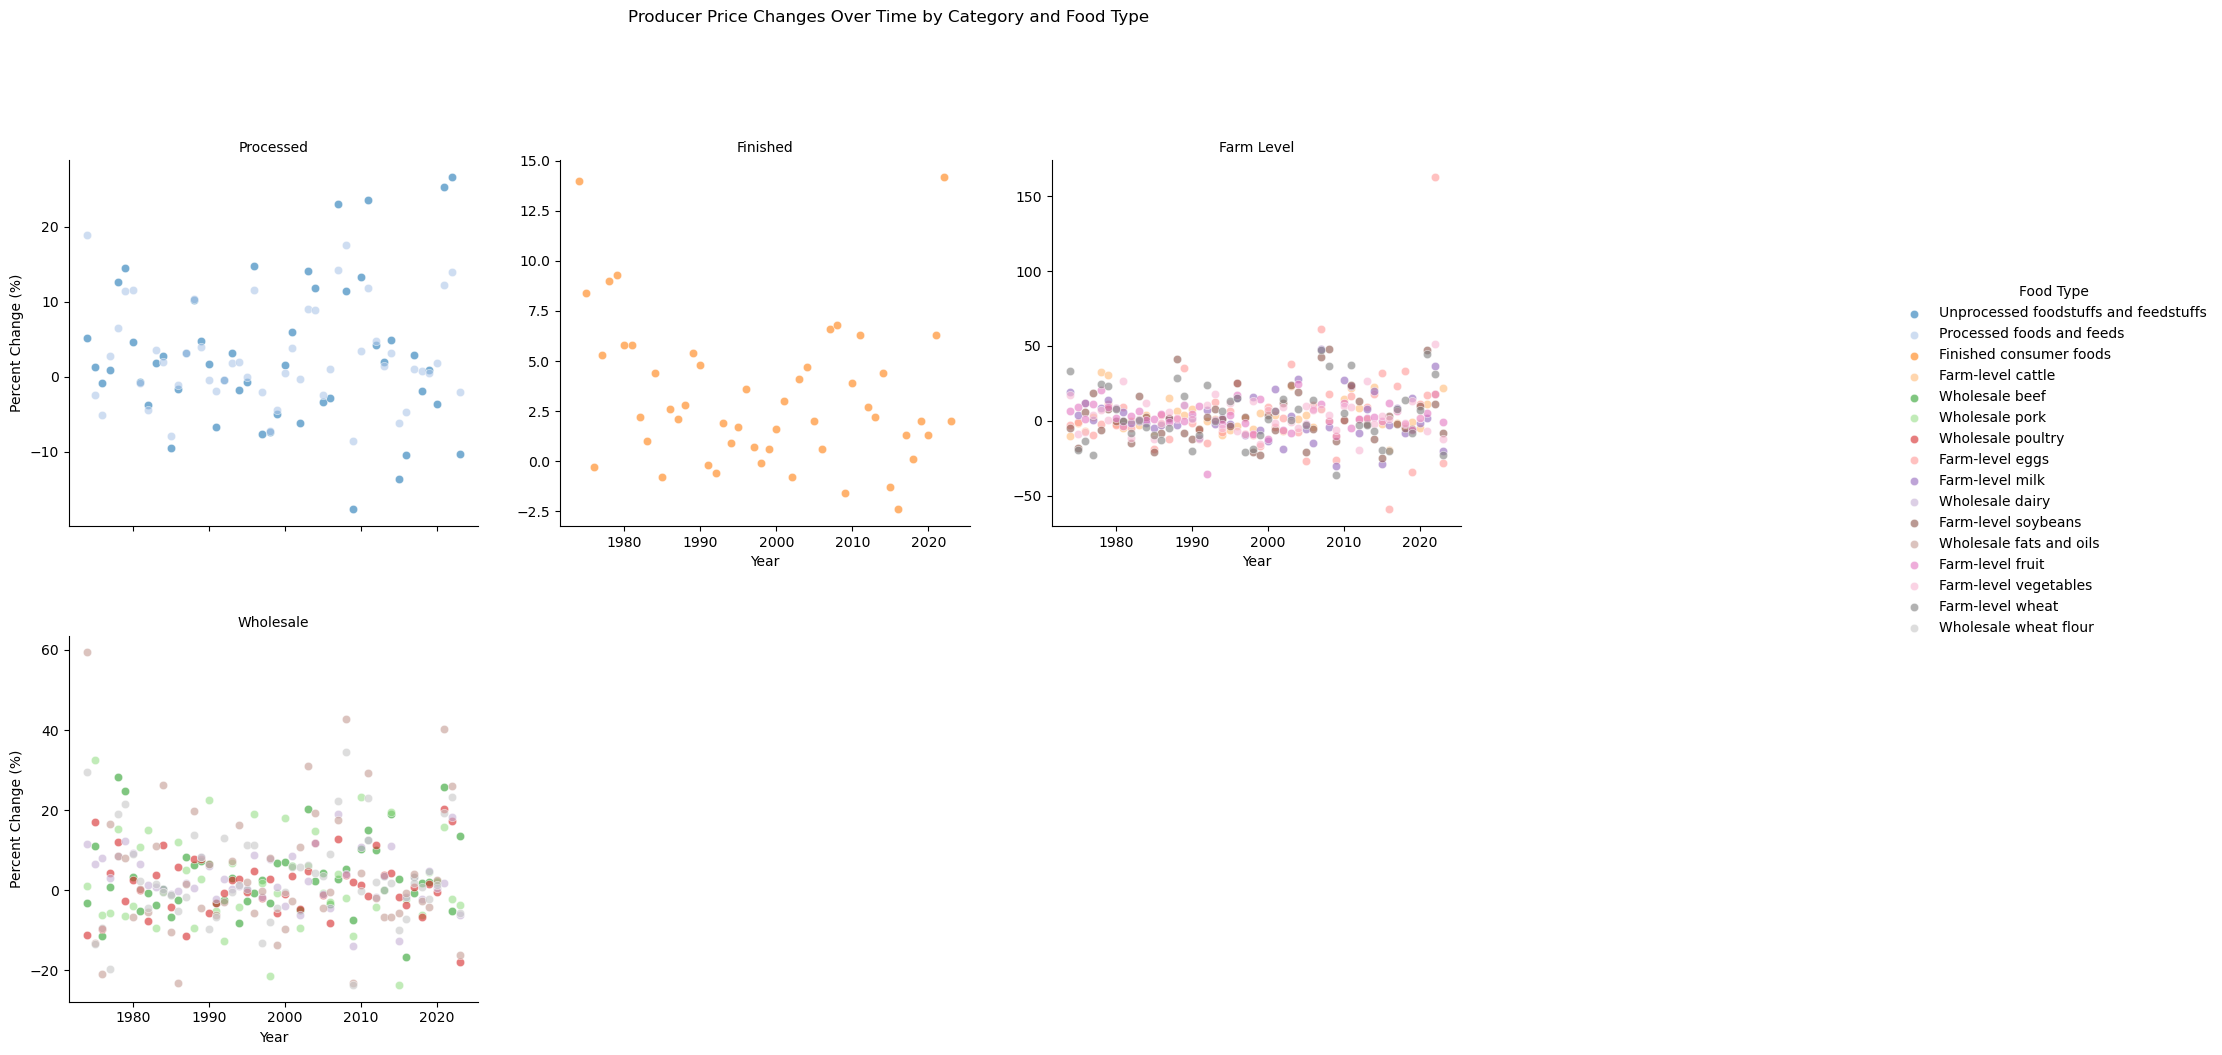

In [ ]:
## Producer Data Visualization 

print("Producer Data Summary:")
print(historical_producer_price_changes.head())

# scatterplot faceted 
g = sns.FacetGrid(
    historical_producer_price_changes,
    col="Category",
    col_wrap=3,
    height=5,
    sharey=False,
    hue="Producer Price Index item",
    palette="tab20",
)

# scatter + line 
g.map_dataframe(
    sns.scatterplot,
    x="Year",
    y="Percent change",
    alpha=0.6,  
)

# legend + title 
g.add_legend(title="Food Type", bbox_to_anchor=(1.05, 0.6), loc='center left')
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Percent Change (%)")
g.fig.suptitle("Producer Price Changes Over Time by Category and Food Type", y=1.05)

# layout 
plt.subplots_adjust(top=0.9, hspace=0.3, wspace=0.2)
plt.show()

While this visualiation does not reveal a strong linear relationship between Producer Price Changes Over Time when faceted by Categor and Food Type, it suggests that generally Producer Price Index percentage changes for Farm Level and Wholesale Products experience more drastic changes compared to Processed. This could suggest that perhaps Processed Foods experience less drastic changes in profits for producers, and thus could drive for preference for Processed Foods from a Producer's standpoint as the Producer Price Index appears more stable. 

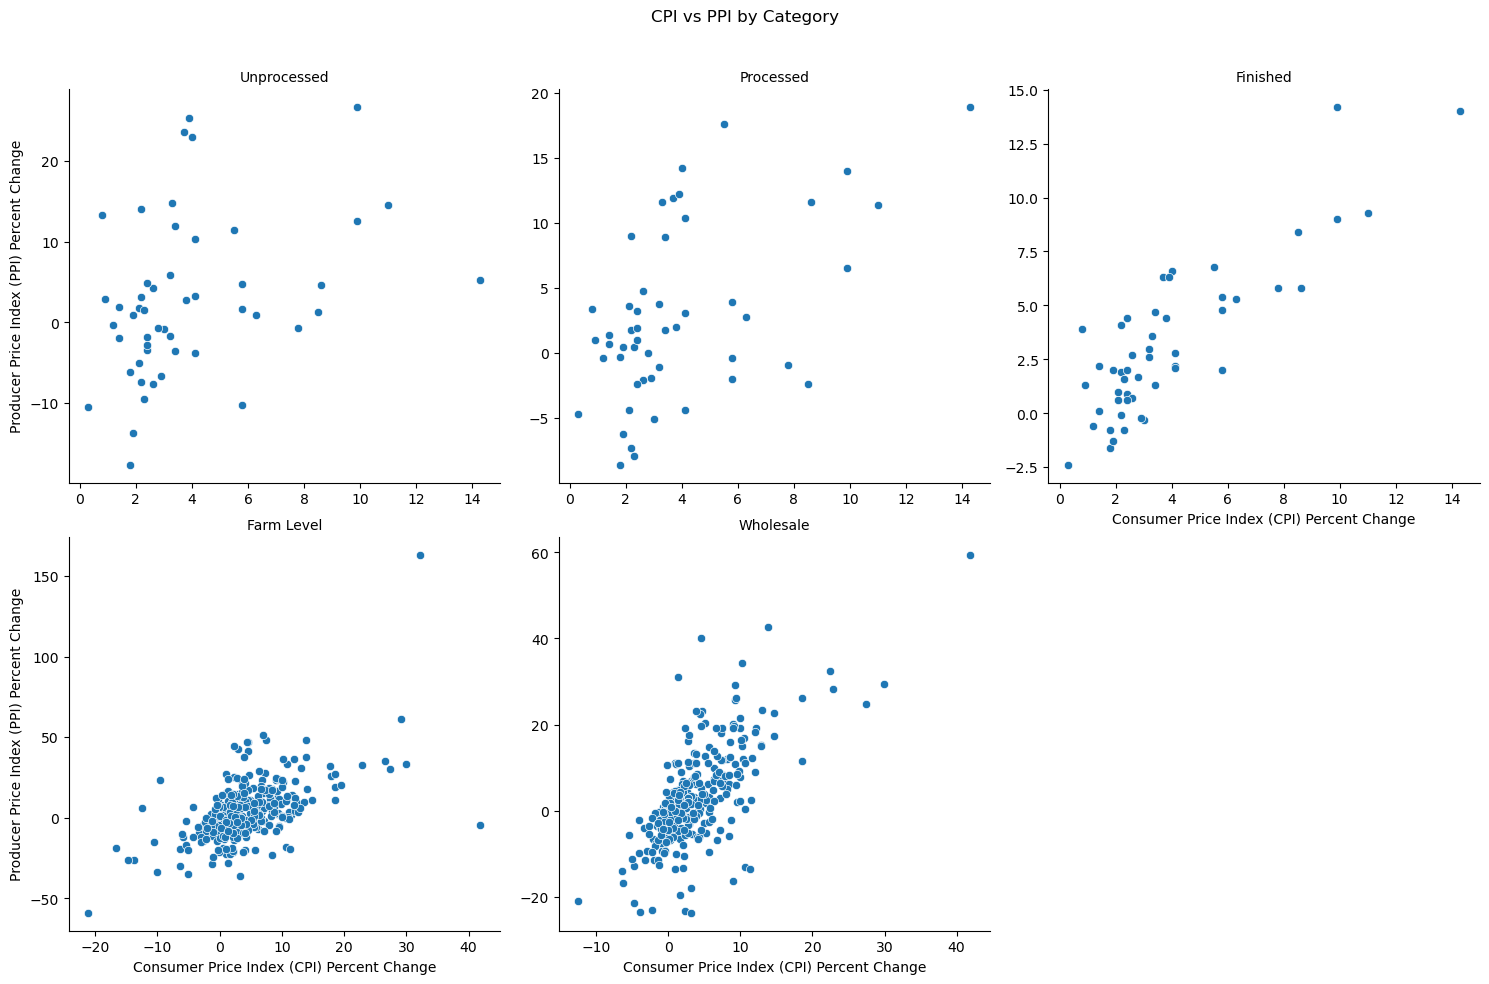

In [73]:
## PPI vs CPI 

g = sns.FacetGrid(cpi_ppi, col="Category", col_wrap=3, height=5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="Percent change_consumer", y="Percent change_producer")

# Adding titles and labels
g.set_axis_labels("Consumer Price Index (CPI) Percent Change", "Producer Price Index (PPI) Percent Change")
g.set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("CPI vs PPI by Category")

plt.show()


From this visualization, we can see that for Farm Level nd Finished Products, theres a clear positive moderately strong linear relationship between CPI Change and PPI Change, however, the slope is difficult to compare due to differing interval values. In this data set, "Finished" refers to packaged, ready to eat goods like cookies, snacks, etc. On the other hand, farm level is typical raw products like meats, produce, etc. sourced directly from farms. Thus, our next step would be to create a linear regression model to directly understand these slopes and perhaps group "Finished" and "Processed" products into an "Unhealthy" food category, and "Farm Level" and "Unprocessed" together into a Healthy category. 

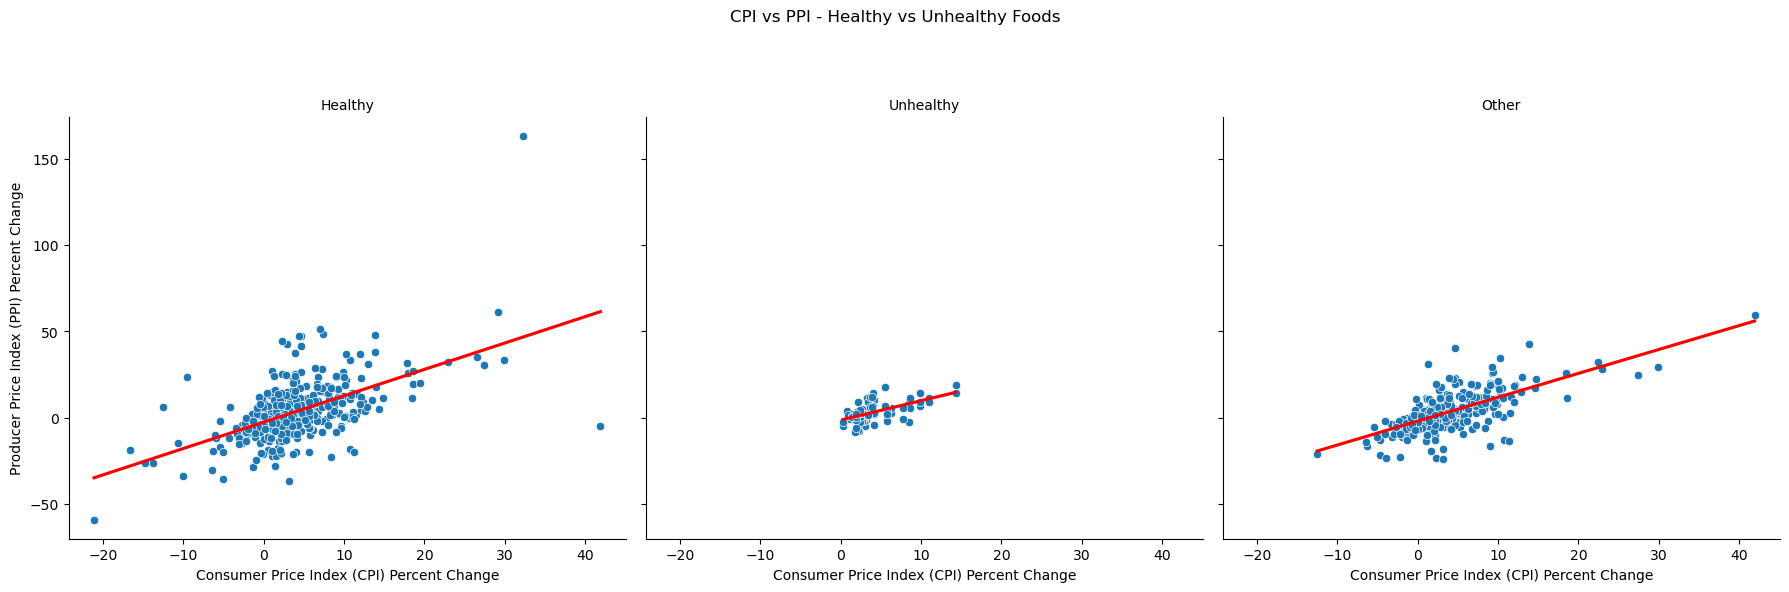

In [80]:
## grouped visual 

# categorize as "Healthy" or "Unhealthy"
def categorize_health(category):
    if category in ["Finished", "Processed"]:
        return "Unhealthy"
    elif category in ["Unprocessed", "Farm Level"]:
        return "Healthy"
    else:
        return "Other"

# Apply the categorization
cpi_ppi['Health Category'] = cpi_ppi['Category'].apply(categorize_health)

# Facet plot with scatter 
g = sns.FacetGrid(cpi_ppi, col="Health Category", height=6)
g.map_dataframe(sns.scatterplot, x="Percent change_consumer", y="Percent change_producer")

# line without standard error
for ax, category in zip(g.axes.flat, cpi_ppi['Health Category'].unique()):
    data = cpi_ppi[cpi_ppi['Health Category'] == category]
    sns.regplot(data=data, x="Percent change_consumer", y="Percent change_producer", ax=ax, scatter=False, color='red', ci=None)

# Adjusting the titles and labels
g.set_axis_labels("Consumer Price Index (CPI) Percent Change", "Producer Price Index (PPI) Percent Change")
g.set_titles("{col_name}")

# Main title
plt.subplots_adjust(top=0.8)
g.fig.suptitle("CPI vs PPI - Healthy vs Unhealthy Foods")

plt.show()


From here, we decided to look at the linear regression models directly. 

In [83]:
## linear Regression Models 

categories = cpi_ppi['Health Category'].unique()

for category in categories:

    data = cpi_ppi[cpi_ppi['Health Category'] == category]

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        data['Percent change_consumer'],
        data['Percent change_producer']
    )

    # Print results
    print(f"Category: {category}")
    print(f"  Slope: {slope:.4f}")
    print(f"  Intercept: {intercept:.4f}")
    print(f"  R-squared: {r_value**2:.4f}")
    print(f"  P-value: {p_value:.4e}")
    print(f"  Standard Error: {std_err:.4f}")
    print("-" * 50)

Category: Healthy
  Slope: 1.5293
  Intercept: -2.6335
  R-squared: 0.3166
  P-value: 1.2883e-34
  Standard Error: 0.1129
--------------------------------------------------
Category: Unhealthy
  Slope: 1.1258
  Intercept: -1.4346
  R-squared: 0.3764
  P-value: 1.1533e-11
  Standard Error: 0.1464
--------------------------------------------------
Category: Other
  Slope: 1.3854
  Intercept: -2.0487
  R-squared: 0.4702
  P-value: 5.2817e-43
  Standard Error: 0.0852
--------------------------------------------------


Our linear regression models suggest that for Healthy foods, for every one percent increase in CPI, we would expect, on average, for the PPI to increase by around 1.53%, while for Unhealthy foods, for every one percent increase in CPI, we would expect, on average, for the PPI to increase by 1.13%. This could possibly suggest that producers make more profit when the price for consumers are increased for Healthy foods compared to Unhealthy foods, and thus producers may be incentivized to increase the price of Healthy foods over those of Unhealthy. 

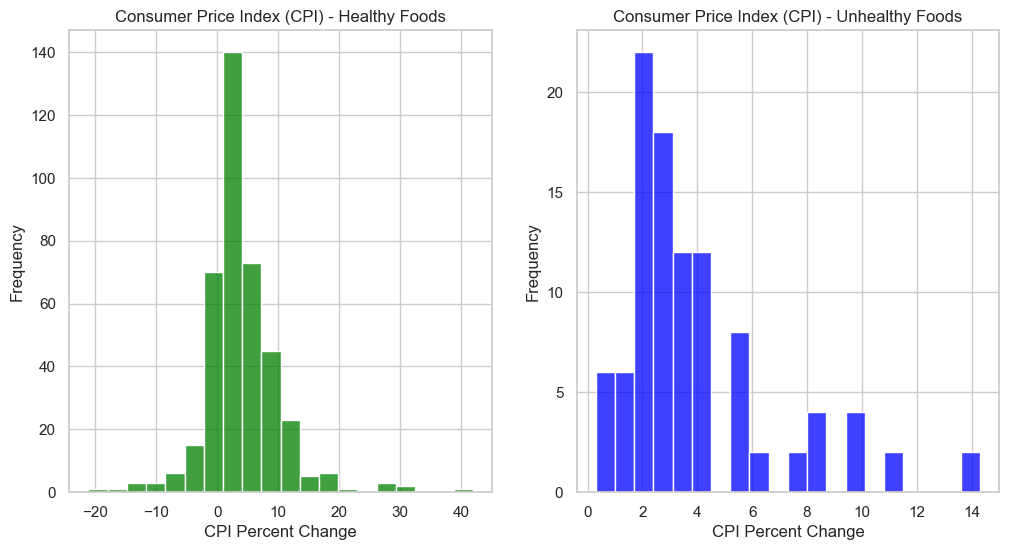

2.9
2.95


In [93]:
sns.set(style="whitegrid")

# figure size 
plt.figure(figsize=(12, 6))

#healthy 
plt.subplot(1, 2, 1)
sns.histplot(data=cpi_ppi[cpi_ppi['Health Category'] == 'Healthy'], 
             x='Percent change_consumer', 
             kde=False, 
             bins=20, 
             color='green')
plt.title('Consumer Price Index (CPI) - Healthy Foods')
plt.xlabel('CPI Percent Change')
plt.ylabel('Frequency')

# unhealthy 
plt.subplot(1, 2, 2)
sns.histplot(data=cpi_ppi[cpi_ppi['Health Category'] == 'Unhealthy'], 
             x='Percent change_consumer', 
             kde=False, 
             bins=20, 
             color='blue')
plt.title('Consumer Price Index (CPI) - Unhealthy Foods')
plt.xlabel('CPI Percent Change')
plt.ylabel('Frequency')


plt.show()

median_healthy = cpi_ppi[cpi_ppi['Health Category'] == 'Healthy']['Percent change_consumer'].median()
median_unhealthy = cpi_ppi[cpi_ppi['Health Category'] == 'Unhealthy']['Percent change_consumer'].median()
print(median_healthy)
print(median_unhealthy)

/var/folders/f2/j604gtvx78jgc87l3dgjs5k80000gn/T/ipykernel_96726/3267564952.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


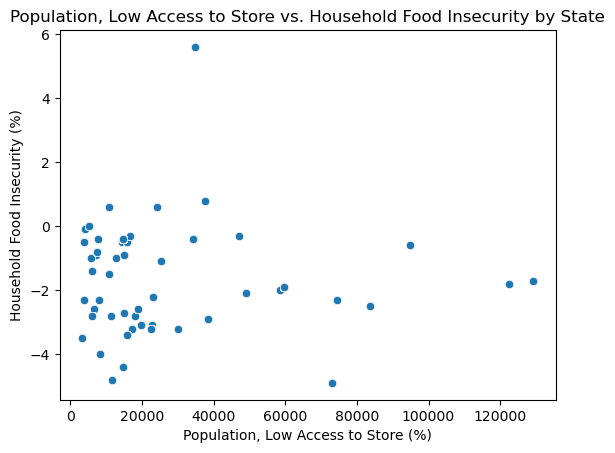

In [68]:
# Household food insecurity (%), three-year average, 2015-17 vs Population, low access to store, 2015

# Filter low access population data
filtered_data_low_access = state_and_county[state_and_county['Variable_Code'] == 'LACCESS_POP15'].copy()
filtered_data_low_access['Low Access Population'] = pd.to_numeric(filtered_data_low_access['Value'], errors='coerce')

state_avg_low_access = filtered_data_low_access.groupby('State')['Low Access Population'].mean().reset_index()

# Filter household insecurity data
filtered_data_insecurity = state_and_county[state_and_county['Variable_Code'] == 'CH_FOODINSEC_14_17'][['State', 'Value']].copy()
filtered_data_insecurity.rename(columns={'Value': 'Household Insecurity'}, inplace=True)
filtered_data_insecurity['Household Insecurity'] = pd.to_numeric(filtered_data_insecurity['Household Insecurity'], errors='coerce')

# Merge the two datasets on FIPS code to align counties correctly
merged_data = filtered_data_insecurity.merge(state_avg_low_access, on='State', how='left')

# Create scatter plot
sns.scatterplot(
    data=merged_data,
    x='Low Access Population',
    y='Household Insecurity',
    palette='tab20',
    legend = False
)

plt.title("Population, Low Access to Store vs. Household Food Insecurity by State")
plt.xlabel("Population, Low Access to Store (%)")
plt.ylabel("Household Food Insecurity (%)")

plt.show()

In [ ]:
# median household income vs. food insecurity 

In [ ]:




# histogram - compare socioeconomic groups w food insecurity